In [519]:
import pandas as pd
import numpy as np
import quandl
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, RNN, GRU, SimpleRNN
from keras.models import load_model
import keras
import h5py
import requests
import os

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#quandl.ApiConfig.api_key = "zFtyXTJz6DTqqdvEy2gi"

In [ ]:
#Stock Data (DBA and WEAT not available from here)
#data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'close'] }, ticker = ['DBA'], date = { 'gte': '2012-01-01', 'lte': '2018-04-13' })

### Futures: Continuous contracts (W# - contract # ahead)

In [2]:
#continuous futures W1 is front month
#W1 may18 prices start 3/15/18..futures trade until biz day before 15th of settle month
#data = quandl.get('CHRIS/CME_W7')

In [3]:
#data.to_csv('CME_W7.csv')

In [4]:
#data.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2014-12-24,631.5,631.5,631.5,631.0,17.0,631.0,2.0,144.0
2014-12-26,631.0,631.0,631.0,631.0,0.0,631.0,0.0,146.0
2014-12-29,634.5,634.5,634.5,634.5,3.5,634.5,3.0,146.0
2014-12-30,629.0,629.0,625.0,624.5,10.0,624.5,10.0,147.0
2014-12-31,613.0,613.0,613.0,613.0,11.5,613.0,0.0,151.0


### Futures: Individual contracts (all data)

In [ ]:
#individual contract (July 2018)
#data = quandl.get('CME/WN2018')
#data = quandl.get('CME/WK2018')  #may2018'
#data = quandl.get('CME/WH2018')  #mar2018


In [ ]:
#data.iloc[635:,[3]]

### Combining the Financial data sets by Date

In [65]:
# dat = pd.read_csv("Data/CME_W4.csv")
# dat = dat.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpIntPvD'})
# print(dat.head())
# print(len(dat))
# dat.dtypes

# i = 1
# cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']
# dat = dat[cols]
# cols2 = ['W'+str(i) + "_" + x for x in cols[1:]]
# cols2.insert(0,'Date')
# dat.columns = cols2
# dat.head()

# Import, Merge, Clean Data

### Combine all the Futures Contract Data (5 futures files (W1-W5) and 4 stocks )

In [323]:
def fixDate(inDate):
    lst = inDate.split('/')
    if lst[2] < '20':
        lst[2] = '20'+lst[2]
    else:
        lst[2] = '19'+lst[2]
    return '/'.join(lst)
    
import glob

cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']

#get futures data files, sort by 13th char (digit)
filenamesFUT = glob.glob('./Data/CME_W*.csv')
filenamesFUT = sorted(filenamesFUT, key=lambda x: x[12])

#for each file, subset/clean columns, join to W1 by date
for file in filenamesFUT:
    lst = file.split('W')
    cNum = int(lst[1][:1])
    df = pd.read_csv(file)
    
    #W1-3 have date without century, add full year
    if cNum <= 3:
        df['Date'] = df['Date'].apply(fixDate)
    df['Date'] = pd.to_datetime(df['Date'])
    
    df = df.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpInt'})
    df = df[cols]
    colsTxt = ['W'+str(cNum) + "_" + x for x in cols[1:]]
    colsTxt.insert(0, 'Date')
    df.columns = colsTxt

    if cNum == 1:
        dat = df
    else:
        dat = dat.merge(df, how='left', on='Date')

In [324]:
dat.columns

Index(['Date', 'W1_Open', 'W1_High', 'W1_Low', 'W1_Last', 'W1_Vol', 'W1_OpInt',
       'W3_Open', 'W3_High', 'W3_Low', 'W3_Last', 'W3_Vol', 'W3_OpInt'],
      dtype='object')

### Add Equity data

In [325]:
filenames = glob.glob('./Data/*.csv')
filenamesEQ = [x for x in filenames if x not in filenamesFUT]

colsEQ = ['Date','Close']

for file in filenamesEQ:
    if 'financialALL' not in file and 'imputed' not in file:
        df = pd.read_csv(file, parse_dates=[0])
        df = df[colsEQ]
    
        #extract ticker
        ticker = file.split('/')[2].split('.')[0]

        df.columns = ['Date', ticker]
        
        #merge with futures data
        dat = dat.merge(df, how='left', on='Date')

In [326]:
#keep only the W3 futures contract (3 months ahead rolling contract)
dat = dat[['Date', 'W3_Open', 'W3_High', 'W3_Low', 'W3_Last', 'W3_Vol', 'W3_OpInt', 'ADM',
     'BG', 'WEAT', 'DBA']]

#change col names
dat.columns = ['Date', 'FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close', 'FUT_Vol', 'FUT_OpInt', 'ADM',
     'BG', 'WEAT', 'DBA']

dat.head()

,Date,FUT_Open,FUT_High,FUT_Low,FUT_Close,FUT_Vol,FUT_OpInt,ADM,BG,WEAT,DBA
0,1959-07-01,197.3,198.1,197.2,197.4,640,2060,NaN,NaN,NaN,NaN
1,1959-07-02,197.7,198.0,197.4,197.5,339,2169,NaN,NaN,NaN,NaN
2,1959-07-06,198.2,198.5,198.0,198.1,1073,2649,NaN,NaN,NaN,NaN
3,1959-07-07,198.4,198.4,197.2,197.2,996,3213,NaN,NaN,NaN,NaN
4,1959-07-08,197.6,197.6,195.4,195.4,1006,3803,NaN,NaN,NaN,NaN


In [327]:
# make Date the index
dat = dat.set_index('Date')

#save to csv
dat.to_csv("./Data/financialALL.csv")

### Split data into 3 datasets (futures, stocks, weather)

In [328]:
futures = dat[['FUT_Open','FUT_High','FUT_Low','FUT_Close','FUT_Vol','FUT_OpInt']]
stocks = dat[['ADM','BG','WEAT','DBA']]
stocks.dropna(inplace=True)

In [329]:
weather = pd.read_csv("./Data/final_weather_imputed.csv", header=0)
weather['Date'] = pd.to_datetime(weather['day'])
weather.drop(columns=['day'], inplace=True)
weather.set_index('Date', inplace=True)
weather.head()

,1F0_avg_rh,1F0_avg_wind_drct,1F0_avg_wind_speed_kts,1F0_climo_high_f,1F0_climo_low_f,1F0_climo_precip_in,1F0_max_dewpoint_f,1F0_max_rh,1F0_max_temp_f,1F0_min_dewpoint_f,...,WWR_max_dewpoint_f,WWR_max_rh,WWR_max_temp_f,WWR_min_dewpoint_f,WWR_min_rh,WWR_min_temp_f,WWR_precip_in,WWR_snow_in,WWR_snowd_in,WWR_X1
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,88.6985,4.95102,3.557650,54.7,32.5,0.06,37.0,100.0,43.0,37.0,...,34.0,100.0000,37.0,30.0,86.6944,30.0,0.08,-99.0,-99.0,0.0
2005-02-01,85.1454,30.55420,5.152340,54.9,32.6,0.07,39.0,100.0,43.0,37.0,...,34.0,100.0000,36.0,34.0,80.5077,34.0,0.00,-99.0,-99.0,1.0
2005-02-02,86.7985,355.15000,3.563940,55.0,32.8,0.08,37.0,100.0,43.0,34.0,...,34.0,100.0000,46.0,30.0,60.7869,30.0,0.00,-99.0,-99.0,2.0
2005-02-03,73.9092,351.57600,1.132680,55.2,33.0,0.06,36.0,100.0,55.0,28.0,...,37.0,92.9165,61.0,30.0,28.7724,30.0,0.00,-99.0,-99.0,3.0
2005-02-04,69.7364,211.26100,0.581704,55.4,33.2,0.07,37.0,100.0,59.0,28.0,...,34.0,93.0280,63.0,34.0,25.3208,34.0,0.00,-99.0,-99.0,4.0


# Feature Engineering

### OHLC Average

Many traders believe in technical analysis, forecasting prices by analyzing statistics based on trading activity. One particular metric watched is the OHLC average which is the average of the Open, High, Low, and Closing prices of a security. 

In [330]:
#add OHLC for each of the futures contracts
futures['FUT_OHLC'] = np.sum(futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close']],axis=1) / 4

### Moving Averages

In [331]:
MoveAvg = [50,100,200]
for ma in MoveAvg:
    futures['FUT_{}MA'.format(ma)] = futures['FUT_Close'].rolling(window=ma).mean()

### Percent Change

In [332]:
futures['FUT_%Chg'] = futures['FUT_Close'].pct_change()

### Closing price one month ahead (will be the label)

In [333]:
timeShift = 22  #~one month of trading days

In [334]:
futures['FUT_CloseAhead'] = futures['FUT_Close'].shift(-timeShift)

In [335]:
futures.dropna(inplace=True)

### Normalize the data  (call function for whichever cols we want to normalize)

In [340]:
def normalizeData(data):
    minMax = MinMaxScaler()
    normData = minMax.fit_transform(data.values.reshape(-1,1)).ravel()
    return normData

In [464]:
#moving FUT_Cose to 2nd to last col
futures = futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt',
       'FUT_OHLC', 'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close',
       'FUT_CloseAhead']]

In [488]:
#normalize a subset of the data
fut_norm = futures.iloc[:,:].apply(normalizeData, axis=0)
stk_norm = stocks.iloc[:,:].apply(normalizeData, axis=0)
weather_norm = weather.iloc[:,:].apply(normalizeData, axis=0)

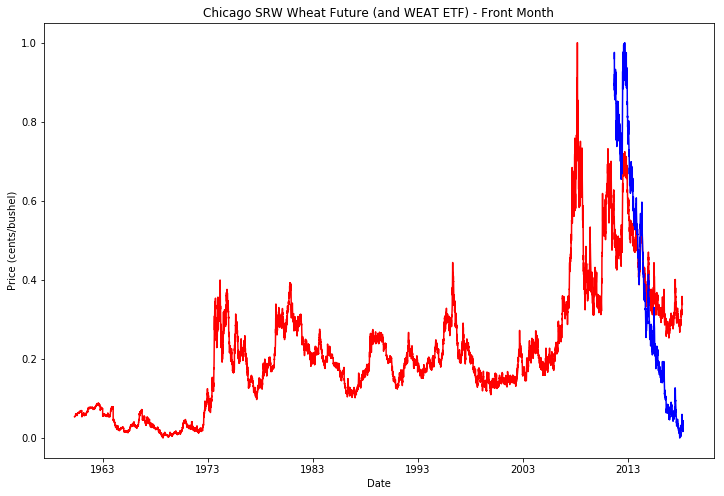

In [489]:
plt.figure(figsize=(12,8))
plt.plot(fut_norm['FUT_Close'], color='r', label='W1')
plt.plot(stk_norm['WEAT'], color='b')
plt.xlabel('Date')
plt.ylabel('Price (cents/bushel)')
plt.title('Chicago SRW Wheat Future (and WEAT ETF) - Front Month');

### Prep Data for NN

In [490]:
fut_weather_norm = weather_norm.merge(fut_norm, left_index=True, right_index=True)

In [491]:
fut_stk_weather_norm = stk_norm.merge(fut_weather_norm, left_index=True, right_index=True)



In [492]:
def prepData(df, window=30):
    
    newData = []

    data = df.as_matrix()
    
    for i in range(len(data) - window): 
        newData.append(data[i: i + (window+1)]) # moving window of data, add one as index starts at 0
    
    #result = np.empty(len(newData), dtype=object)
    #result[:]= [d1, d2]
    #result[:] = newData
    
    newData = np.array(newData)
    split = int(round(len(newData)/3))

    XTrain = newData[:split, :-1]    # data for days d in a month
    yTrain = newData[:split,-1][:,-1] # data for day  d+1 only last col (FUT_CloseAhead)
    
    XValid = newData[split:(2*split),:-1]
    yValid = newData[split:(2*split),-1][:,-1]
    
    XTest = newData[(2*split):,:-1]
    yTest = newData[(2*split):,-1][:,-1]
    

    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [XTrain, yTrain, XValid, yValid, XTest, yTest]

In [500]:
## >>>>> label is FUT_CloseAhead (close price 22 days forward)  ... should we just use FUT_Close?

#just futures data (back to 1960)
XTrain, yTrain, XValid, yValid, XTest, yTest = prepData(fut_norm, timeShift)

#futures and weather (back to 2005)
XTrainFW, yTrainFW, XValidFW, yValidFW, XTestFW, yTestFW = prepData(fut_weather_norm, timeShift)

#futures, weather, and stocks (back to 2011)
XTrainFSW, yTrainFSW, XValidFSW, yValidFSW, XTestFSW, yTestFSW = prepData(fut_stk_weather_norm, timeShift)

### Check if shapes look ok

In [501]:
print(XTrain.shape, yTrain.shape, XValid.shape, yValid.shape, XTest.shape, yTest.shape)

(4855, 22, 12) (4855,) (4855, 22, 12) (4855,) (4855, 22, 12) (4855,)


In [502]:
print(XTrainFW.shape, yTrainFW.shape, XValidFW.shape, yValidFW.shape, XTestFW.shape, yTestFW.shape)

(1084, 22, 1500) (1084,) (1084, 22, 1500) (1084,) (1084, 22, 1500) (1084,)


In [503]:
print(XTrainFSW.shape, yTrainFSW.shape, XValidFSW.shape, yValidFSW.shape, XTestFSW.shape, yTestFSW.shape)

(528, 22, 1504) (528,) (528, 22, 1504) (528,) (527, 22, 1504) (527,)


## Neural Network (RNN, GRU, LSTM)

In [546]:
def build_NN(inShape, neuronList, nnType='RNN'):
    
    model = Sequential()
    model.add(Dense(neuronList[0], input_shape=(inShape[0], inShape[1])))  #input layer
    
    if nnType == 'RNN':    
        model.add(SimpleRNN(neuronList[1], return_sequences=True))
        model.add(SimpleRNN(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'GRU':
        model.add(GRU(neuronList[1], return_sequences=True))
        model.add(GRU(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'LSTM':
        model.add(LSTM(neuronList[1], return_sequences=True)) #stacking LSTM's need return_seq to get 3D output
        model.add(LSTM(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))      
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'BASE':
        model.add(Dense(neuronList[1], activation='relu'))
        model.add(Dense(neuronList[2], activation='relu'))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    else:
        print('should not be here')
    
    model.add(Dense(neuronList[5], activation='linear')) #output layer
      
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.summary() 

    return model

In [547]:
#get the input shapes for each dataset to use input layer of NN model
inShapeF = [timeShift, len(fut_norm.columns)]
inShapeFW = [timeShift, len(fut_weather_norm.columns)]
inShapeFSW = [timeShift, len(fut_stk_weather_norm.columns)]

#neurons list
neurons = [512, 256, 256, 64, 32, 1]
epochs = 60
batchSize = 50

### Build Models for futures only data

In [548]:
modelBASE_F = build_NN(inShapeF, neurons, nnType='Base')
modelRNN_F = build_NN(inShapeF, neurons, nnType='RNN')
modelGRU_F = build_NN(inShapeF, neurons, nnType='GRU')
modelLSTM_F = build_NN(inShapeF, neurons, nnType='LSTM')

should not be here
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 22, 512)           6656      
_________________________________________________________________
dense_132 (Dense)            (None, 22, 1)             513       
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 22, 512)           6656      
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 22, 256)           196864    
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 256)               131328    
_______________________________________________________

In [549]:
modelBASE_F.fit(XTrain, yTrain, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

ValueError: Error when checking target: expected dense_132 to have 3 dimensions, but got array with shape (4855, 1)

In [ ]:
##------------------------------
##  Below code is not ours, am running it to help debug our
##------------------------------

In [553]:

# from lstmstock import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
from keras import backend as K
import quandl

In [554]:
quandl.ApiConfig.api_key = 'zpFWg7jpwtBPmzA8sT2Z'
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 90
stock_name = 'AAPL'

In [555]:

def get_stock_data(stock_name, normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = quandl.get_table('WIKI/PRICES', ticker = stock_name)
    df.drop(['ticker', 'open', 'high', 'low', 'close', 'ex-dividend', 'volume', 'split_ratio'], 1, inplace=True)
    df.set_index('date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'adj_open': 'Open', 'adj_high': 'High', 'adj_low': 'Low', 'adj_volume': 'Volume', 'adj_close': 'Adj Close'}, inplace=True)
    
    # Percentage change
    df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
        df['Pct'] = min_max_scaler.fit_transform(df['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
                
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [556]:
df = get_stock_data(stock_name, ma=[50, 100, 200])

In [557]:

def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

                Open      High       Low    Volume       Pct      50ma  \
date                                                                     
1981-09-30  0.000333  0.000341  0.000347  0.006603  0.618942  0.000667   
1981-10-01  0.000333  0.000341  0.000347  0.008103  0.609620  0.000652   
1981-10-02  0.000434  0.000442  0.000449  0.005935  0.705957  0.000642   
1981-10-05  0.000474  0.000492  0.000490  0.005673  0.645236  0.000631   
1981-10-06  0.000474  0.000472  0.000480  0.003687  0.601324  0.000619   

               100ma     200ma  Adj Close  
date                                       
1981-09-30  0.000910  0.000904   0.000344  
1981-10-01  0.000899  0.000899   0.000344  
1981-10-02  0.000889  0.000895   0.000445  
1981-10-05  0.000880  0.000891   0.000486  
1981-10-06  0.000872  0.000886   0.000476  


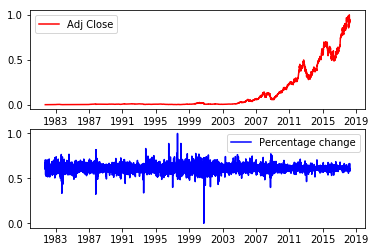

In [558]:
plot_stock(df)

In [559]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    
    result = np.array(result)
    print(result.shape)
    row = round(0.8 * result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * result.shape[0]))

    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    
    print(X_train.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [560]:

X_train, y_train, X_test, y_test = load_data(df, seq_len)

Amount of features = 9
(9177, 23, 9)
Amount of training data = 8259.300000000001
Amount of testing data = 917.7
(7342, 22, 9)


In [561]:
y_train[0]

0.00072883119500762007

In [563]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [564]:
model = build_model(shape, neurons, dropout, decay)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 22, 256)           272384    
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 32)                8224      
_________________________________________________________________
dense_148 (Dense)            (None, 1)                 33        
Total params: 805,953
Trainable params: 805,953
Non-trainable params: 0
_________________________________________________________________


In [566]:
X_train.shape

(7342, 22, 9)

In [567]:
y_train.shape

(7342,)

In [565]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.2,
    verbose=1)

Train on 5873 samples, validate on 1469 samples
Epoch 1/90
5873/5873 [==============================] - 13s 2ms/step - loss: 2.1224e-05 - acc: 1.7027e-04 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 2/90
2048/5873 [=========>....................] - ETA: 7s - loss: 1.7033e-05 - acc: 4.8828e-04

KeyboardInterrupt: 

In [ ]:

def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [ ]:
model_score(model, X_train, y_train, X_test, y_test)

In [ ]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [ ]:
p = percentage_difference(model, X_test, y_test)

In [ ]:
def denormalize(stock_name, normalized_value):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = quandl.get_table('WIKI/PRICES', ticker = stock_name)
    df.drop(['ticker', 'open', 'high', 'low', 'close', 'ex-dividend', 'volume', 'split_ratio'], 1, inplace=True)
    df.set_index('date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'adj_open': 'Open', 'adj_high': 'High', 'adj_low': 'Low', 'adj_volume': 'Volume', 'adj_close': 'Adj Close'}, inplace=True)
    
    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
      
    return new

In [ ]:

def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

In [ ]:
plot_result(stock_name, p, y_test)